## Comandos Linux
Comandos usados para extraer el dataset de Google Drive y remover las clases necesarias


In [ ]:
!unzip "/content/drive/MyDrive/ava_augmented_full.zip" -d "/content"

In [ ]:
!rm /content/valid/rule_of_thirds/*
!rm /content/train/rule_of_thirds/*
!rm /content/test/rule_of_thirds/*

!rmdir /content/valid/rule_of_thirds
!rmdir /content/train/rule_of_thirds
!rmdir /content/test/rule_of_thirds

## Inicio del código de Python

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import copy
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
densenet_model = tf.keras.applications.DenseNet201(include_top=False, input_shape=(256,256,3), weights='imagenet')

74842112/74836368 [==============================] - 0s 0us/step


In [ ]:
densenet_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
model = Sequential()
model.add(densenet_model)
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(units=264, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=264, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=13, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 122880)            0         
_________________________________________________________________
dropout (Dropout)            (None, 122880)            0         
_________________________________________________________________
dense (Dense)                (None, 264)               32440584  
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 264)               69960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 264)               0

In [ ]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [ ]:
train_batches = ImageDataGenerator(rescale=1.0/255.0) \
                .flow_from_directory(directory=train_path, target_size=(256,256), batch_size=16)
valid_batches = ImageDataGenerator(rescale=1.0/255.0) \
                .flow_from_directory(directory=valid_path, target_size=(256,256), batch_size=16)
test_batches = ImageDataGenerator(rescale=1.0/255.0) \
                .flow_from_directory(directory=test_path, target_size=(256,256), batch_size=100, shuffle=False)

Found 24366 images belonging to 13 classes.
Found 3030 images belonging to 13 classes.
Found 3030 images belonging to 13 classes.


In [ ]:
print(train_batches.class_indices)
print(valid_batches.class_indices)
print(test_batches.class_indices)

{'complementary_colors': 0, 'dutones': 1, 'hdr': 2, 'image_grain': 3, 'light_on_white': 4, 'long_exposure': 5, 'macro': 6, 'motion_blur': 7, 'negative_image': 8, 'shallow_dof': 9, 'silhouttes': 10, 'soft_focus': 11, 'vanishing_point': 12}
{'complementary_colors': 0, 'dutones': 1, 'hdr': 2, 'image_grain': 3, 'light_on_white': 4, 'long_exposure': 5, 'macro': 6, 'motion_blur': 7, 'negative_image': 8, 'shallow_dof': 9, 'silhouttes': 10, 'soft_focus': 11, 'vanishing_point': 12}
{'complementary_colors': 0, 'dutones': 1, 'hdr': 2, 'image_grain': 3, 'light_on_white': 4, 'long_exposure': 5, 'macro': 6, 'motion_blur': 7, 'negative_image': 8, 'shallow_dof': 9, 'silhouttes': 10, 'soft_focus': 11, 'vanishing_point': 12}


In [ ]:
imgs, labels = next(train_batches)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 10 columns where
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

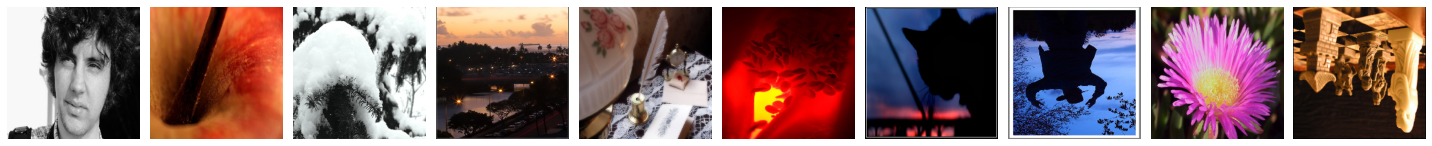

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [ ]:
plotImages(imgs)
print(labels)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 122880)            0         
_________________________________________________________________
dropout (Dropout)            (None, 122880)            0         
_________________________________________________________________
dense (Dense)                (None, 264)               32440584  
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 264)               69960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 264)               0

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0000065), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(curve='PR')])

In [ ]:
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=1)

Epoch 1/10
 317/1523 [=====>........................] - ETA: 4:12 - loss: 3.1785 - accuracy: 0.1020 - auc: 0.0891

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11046 bytes but only got 749. Skipping tag 700
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9664 bytes but only got 749. Skipping tag 34377
  " Skipping tag %s" % (size, len(data), tag)


1523/1523 [==============================] - 381s 228ms/step - loss: 2.7221 - accuracy: 0.1450 - auc: 0.1186 - val_loss: 1.9138 - val_accuracy: 0.4083 - val_auc: 0.4260
Epoch 2/10
1523/1523 [==============================] - 342s 224ms/step - loss: 2.0517 - accuracy: 0.3298 - auc: 0.3236 - val_loss: 1.5062 - val_accuracy: 0.5455 - val_auc: 0.5679
Epoch 3/10
1523/1523 [==============================] - 340s 223ms/step - loss: 1.7293 - accuracy: 0.4438 - auc: 0.4594 - val_loss: 1.3600 - val_accuracy: 0.5776 - val_auc: 0.6184
Epoch 4/10
1523/1523 [==============================] - 340s 223ms/step - loss: 1.5109 - accuracy: 0.5087 - auc: 0.5555 - val_loss: 1.2809 - val_accuracy: 0.5934 - val_auc: 0.6480
Epoch 5/10
1523/1523 [==============================] - 340s 223ms/step - loss: 1.3675 - accuracy: 0.5652 - auc: 0.6140 - val_loss: 1.2547 - val_accuracy: 0.6106 - val_auc: 0.6593
Epoch 6/10
1523/1523 [==============================] - 340s 223ms/step - loss: 1.2041 - accuracy: 0.6111 - auc

In [ ]:
model.save('ava_aug_full_13_10epochs_6162.h5')

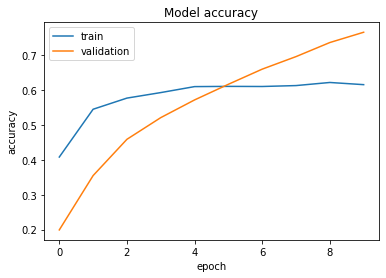

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('DenseNet201 DROPOUT Full augmented 13 Classes 10epochs Adam0000065.jpg')
plt.show()

In [ ]:
predictions = model.predict(x=test_batches, verbose=1)

31/31 [==============================] - 28s 765ms/step


In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

Y = label_binarize(test_batches.classes, [0,1,2,3,4,5,6,7,8,9,10,11,12])
n_classes = Y.shape[1]
avP = average_precision_score(y_true=Y, y_score=predictions) # Average none to see result per class
print(avP)
print(type(avP))
print(avP.size)

0.6532180433994577
<class 'numpy.float64'>
1
